Exploratory Data Analysis 

Import Packages

In [1]:
from ast import literal_eval
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans

Import Data

In [2]:
df = pd.read_excel("albums_final.xlsx")

Clean Data

In [3]:
# drop all rows that don't have genres
df.dropna(subset=["genres"], axis=0, inplace=True)


# convert genres to list
df["genres"] = df["genres"].apply(literal_eval)

Unique Genres
- check how many unique genres there in the data

In [4]:
genres = df["genres"].to_list()
flat_genres = np.hstack(genres)
len(np.unique(flat_genres))

581

Co_occurence dictionary
- Co_occurence dictionary of all genres to see wich are seen most often with eachother 

In [12]:
# Initialize a dictionary to store genre pairs and counts
genre_counts = {}


# Iterate through each row
for genres_list in df["genres"]:
    # Generate all pairs of genres
    pairs = combinations(genres_list, 2)
    for pair in pairs:
        # Update the counts
        genre_counts.setdefault(tuple(sorted(pair)), 0)
        genre_counts[tuple(sorted(pair))] += 1

filtered_genres = {key: value for key, value in genre_counts.items() if value > 20}
# sorted_filtered_genres = dict(sorted(filtered_genres.items(), key=lambda item: item[1]))

# Create a DataFrame from the dictionary
co_occurrence_df = pd.DataFrame(
    filtered_genres.values(),
    index=pd.MultiIndex.from_tuples(filtered_genres.keys()),
    columns=["Count"],
)
# print(co_occurrence_df.sort_values("Count", ascending=False))

Co-occurences heat map

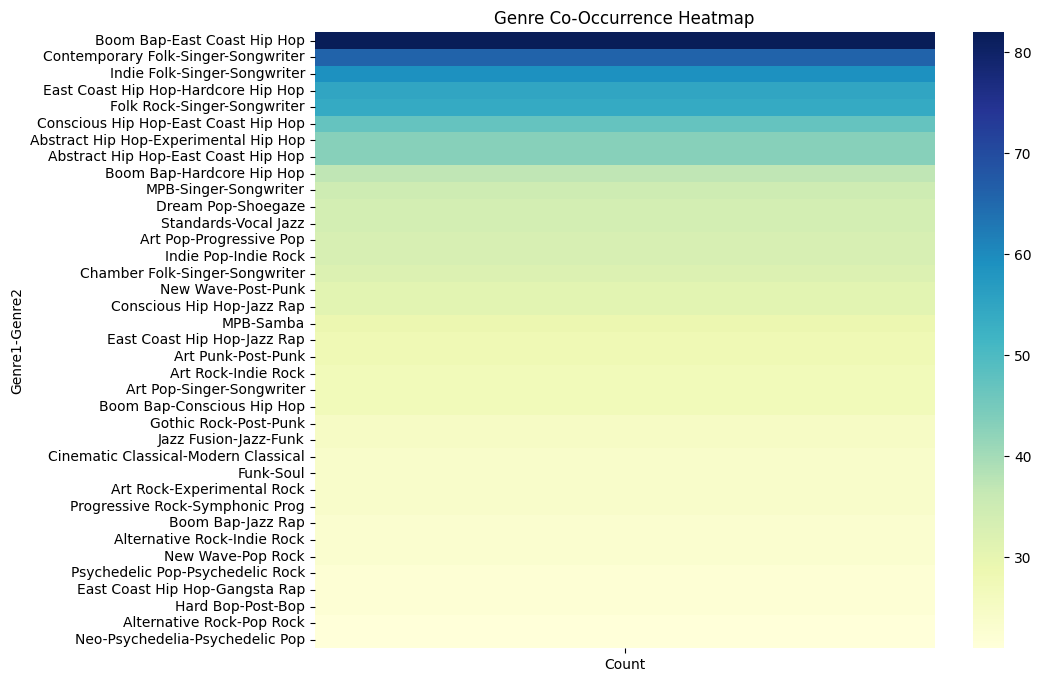

In [13]:
# Create a heatmap to visualize the occurences not as a pivot table
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_df.sort_values("Count", ascending=False), annot=False, cmap="YlGnBu")
plt.title("Genre Co-Occurrence Heatmap")
plt.ylabel("Genre1-Genre2")
plt.show()

Pivot Table and Heatmap of co-occurence matrix

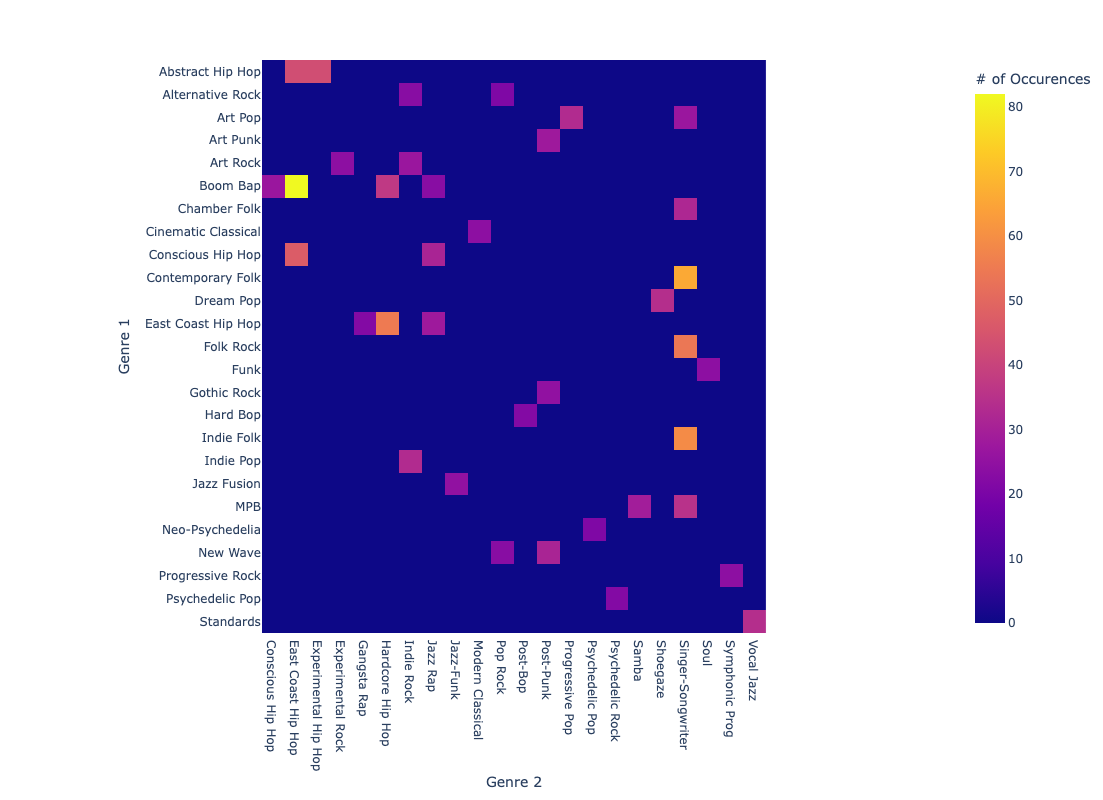

In [14]:
pivot_table = pd.pivot_table(
    co_occurrence_df.reset_index(),
    values="Count",
    index="level_0",
    columns="level_1",
    fill_value=0,
)


# Visualize Pivot Table
px.imshow(
    pivot_table,
    labels=dict(
        x="Genre 2",
        y="Genre 1",
        color="# of Occurences",
    ),
    width=800,
    height=800,
)

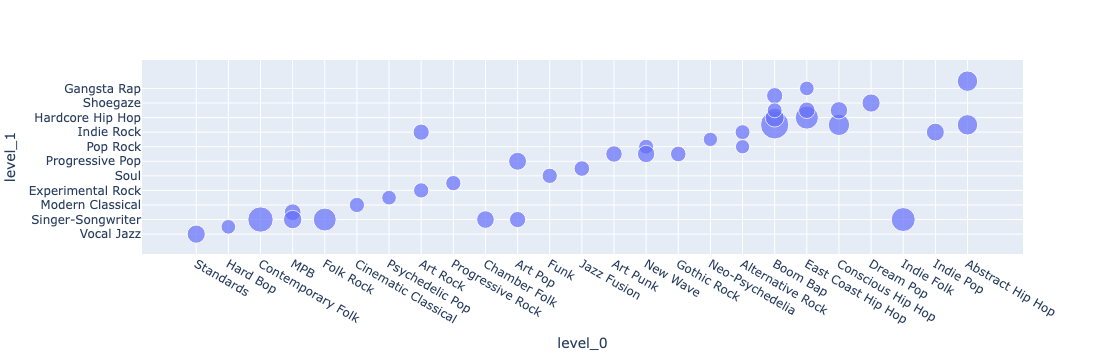

In [16]:
# Scatter plot of the genre occurences
px.scatter(co_occurrence_df.reset_index(), size="Count", x="level_0", y="level_1")


Co-occurence matrix but have the same genres on each axis

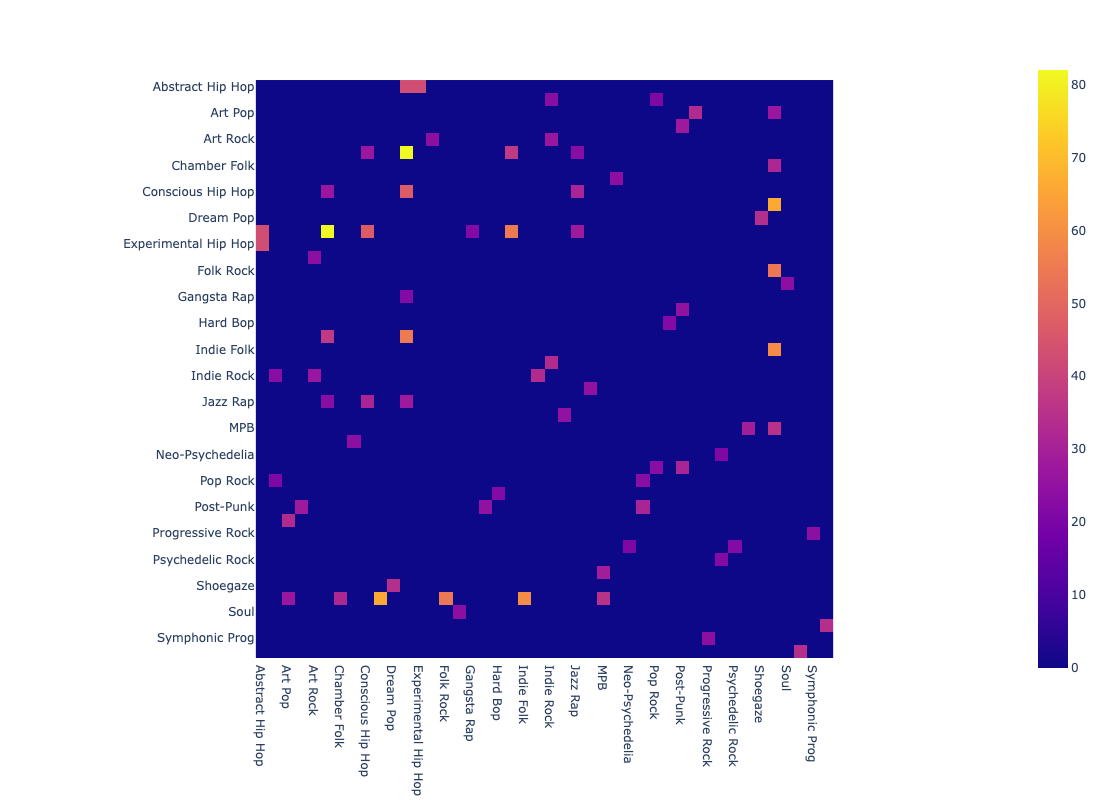

In [37]:
all_genres = set(genre for pair in filtered_genres.keys() for genre in pair)

# Initialize an empty matrix (2D list)
num_genres = len(all_genres)
co_occurrence_matrix = [[0] * num_genres for _ in range(num_genres)]

# Fill in the matrix
genre_to_index = {genre: i for i, genre in enumerate(all_genres)}
for (genre1, genre2), count in filtered_genres.items():
    row, col = genre_to_index[genre1], genre_to_index[genre2]
    co_occurrence_matrix[row][col] = count
    co_occurrence_matrix[col][row] = count  # Symmetric matrix

# Convert to DataFrame (optional)
df_co_occurrence = pd.DataFrame(
    co_occurrence_matrix, index=list(all_genres), columns=list(all_genres)
)
# sort the columns alphabetically 
df_co_occurrence = df_co_occurrence.reindex(sorted(df_co_occurrence.columns), axis=1)


# print(df_co_occurrence)
px.imshow(
    df_co_occurrence.sort_index(), # sort the index alphabetically 
    width=800,
    height=800,
)

Agglomerative Clustering to place the genres into groups so they are more manageable

In [42]:
# Perform hierarchical clustering
n_clusters = 10
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
cluster_labels = clustering.fit_predict(df_co_occurrence)

# Create genre groups based on cluster labels
genre_groups = {i: [] for i in range(n_clusters)}
for genre, label in zip(df_co_occurrence.columns, cluster_labels):
    genre_groups[label].append(genre)
print(genre_groups)

{0: ['Experimental Hip Hop', 'MPB', 'Progressive Pop', 'Soul'], 1: ['Art Pop', 'Art Punk', 'Art Rock', 'Boom Bap', 'Cinematic Classical', 'Contemporary Folk', 'East Coast Hip Hop', 'Experimental Rock', 'Folk Rock', 'Gothic Rock', 'Hard Bop', 'Jazz Fusion', 'Jazz Rap', 'Jazz-Funk', 'Modern Classical', 'Pop Rock', 'Post-Bop', 'Post-Punk', 'Psychedelic Rock', 'Samba', 'Shoegaze', 'Symphonic Prog', 'Vocal Jazz'], 2: ['Indie Pop', 'Progressive Rock', 'Standards'], 3: ['Chamber Folk', 'Dream Pop', 'Gangsta Rap', 'Indie Folk', 'New Wave', 'Singer-Songwriter'], 4: ['Psychedelic Pop'], 5: ['Conscious Hip Hop'], 6: ['Funk'], 7: ['Abstract Hip Hop', 'Alternative Rock', 'Neo-Psychedelia'], 8: ['Indie Rock'], 9: ['Hardcore Hip Hop']}


The genres aren't 